# Fitting 3-States model with PBMC single cell multi omics dataset

In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import time as t
import torch
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import model_selection
import matplotlib.pyplot as plt
from torch.nn.functional import relu
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

Even if we use Torch package we do not recommand to use GPU. The training process can be vectorize in another version of the code, but currently the CPU is faster.

In [4]:
# Import the class
from model import Fit, Trainer
from model import Three_states_analytic_model

In [5]:
# Import the data from pickle objects.
# The data are already preprocess
# and correspond to the fracs , mean and variance of the Gene expression for 500 genes and 20 clusters
# from the PBMC dataset.
import pickle
with open('data/names.pickle', 'rb') as f:
    names = pickle.load(f)
with open('data/means.pickle', 'rb') as f:
    means = torch.tensor(pickle.load(f))
with open('data/vars.pickle', 'rb') as f:
    vars = torch.tensor(pickle.load(f))
with open('data/fracs_adj.pickle', 'rb') as f:
    fracs_adj = torch.tensor(pickle.load(f))
with open('data/clusters.pickle', 'rb') as f:
    clusters = torch.tensor(pickle.load(f) )
with open('data/ncells.pickle', 'rb') as f:
    ncells = torch.tensor(pickle.load(f))

In [6]:
# We logged the data for the training process
log_fracs_adj = torch.log(fracs_adj+torch.tensor(1e-5)).to(default_dtype)
log_means = torch.log(means+torch.tensor(1e-5)).to(default_dtype)
log_vars = torch.log(vars+torch.tensor(1e-5)).to(default_dtype)

In [7]:
# We initialise the instance of Fit. We the number or gene and cluster in our data.
fit = Fit(Three_states_analytic_model, n_pts=20, n_genes=500, lr=1e-2)

In [8]:
# We begin to fit only one Gene as an exemple.
n=0
fit.trainers[n].train(log_fracs_adj[n], log_means[n], log_vars[n], coef_tc=0.0, N_max=10_000, print_=True)

ep: 9999, train: 3.83 in 0.0s    


0.038296292399637215

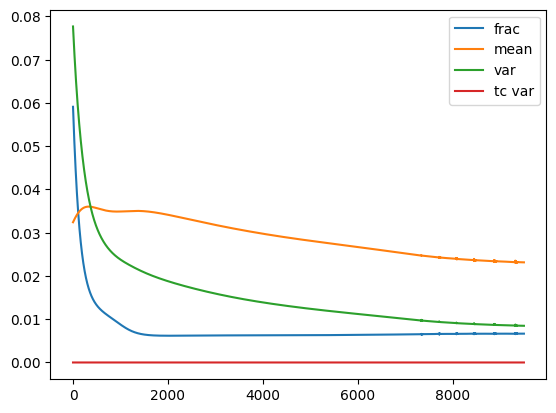

In [9]:
fit.trainers[n].plot(coef_tc=0.0, cut=500)

In [10]:
# we compute the error bar for each cluster according the numbers of cell in each. 
n=0
r_hat = means[n]**2 / (vars[n] - means[n])
r_hat[r_hat < 0] = np.inf
std_mean = np.sqrt(means[n] + means[n]**2 / r_hat) / np.sqrt(ncells)
xerr = 1.96* std_mean

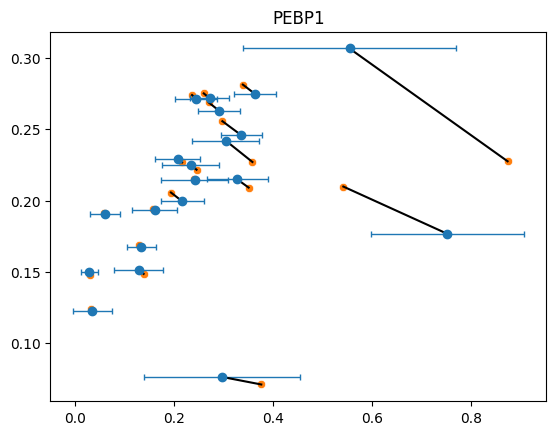

In [11]:
# we plot the data, the computed value and the linked between each dot.
f_, m_, v_, tc_inv = fit.trainers[n].model()
sns.scatterplot(y=fracs_adj[n], x=means[n])
sns.scatterplot(y=f_.detach(), x=m_.detach()).set_title(names[n])
plt.errorbar(y=fracs_adj[n], x=means[n], xerr=xerr, capsize=2, linewidth=1, fmt='o')
for i in range(20):
    ax = sns.lineplot(x=[means[n][i].item(), m_[i].item()], y=[fracs_adj[n][i].item(), f_[i].item()], c='black')

In [12]:
# Here we train another gene as exmple
n=2
fit.trainers[n].train(log_fracs_adj[n], log_means[n], log_vars[n], coef_tc=0.0, N_max=10_000, print_=True)

ep: 9999, train: 0.606 in 0.0s    


0.006058711020997518

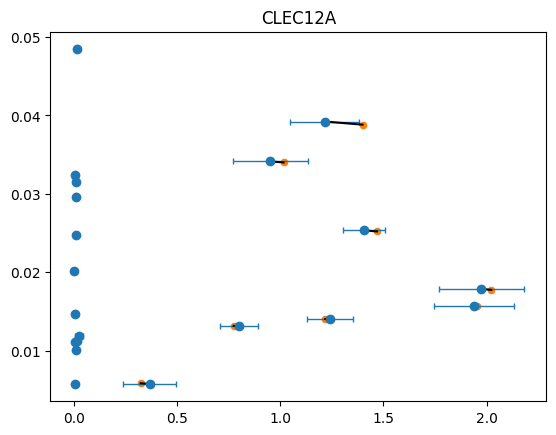

In [13]:
r_hat = means[n]**2 / (vars[n] - means[n])
r_hat[r_hat < 0] = np.inf
std_mean = np.sqrt(means[n] + means[n]**2 / r_hat) / np.sqrt(ncells)
xerr = 1.96* std_mean

f_, m_, v_, tc_inv = fit.trainers[n].model()
sns.scatterplot(y=fracs_adj[n], x=means[n])
sns.scatterplot(y=f_.detach(), x=m_.detach()).set_title(names[n])
plt.errorbar(y=fracs_adj[n], x=means[n], xerr=xerr, capsize=2, linewidth=1, fmt='o')
for i in range(20):
    ax = sns.lineplot(x=[means[n][i].item(), m_[i].item()], y=[fracs_adj[n][i].item(), f_[i].item()], c='black')

In [ ]:
# now we can train the whole dataset, explore the results, and get the parameters for each gene.
fit.train_all(log_fracs_adj, log_means, log_vars, coef_tc=0.0, N_max=10_000, print_=False)